In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
%matplotlib inline

In [2]:
# train, and test data directories
tr_dir = "./images/seg_train/"
te_dir = "./images/seg_test/"

# load datasets
tr_val_dataset = ImageFolder(tr_dir, transform=transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))
te_dataset = ImageFolder(te_dir, transform=transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))

In [3]:
# parameters
batch_size = 16
tr_size = int(len(tr_val_dataset)*0.85)
val_size = len(tr_val_dataset) - tr_size

# split training data
tr_dataset, val_dataset = torch.utils.data.random_split(tr_val_dataset, [tr_size, val_size])

# load into batches
tr_dl = torch.utils.data.DataLoader(tr_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)

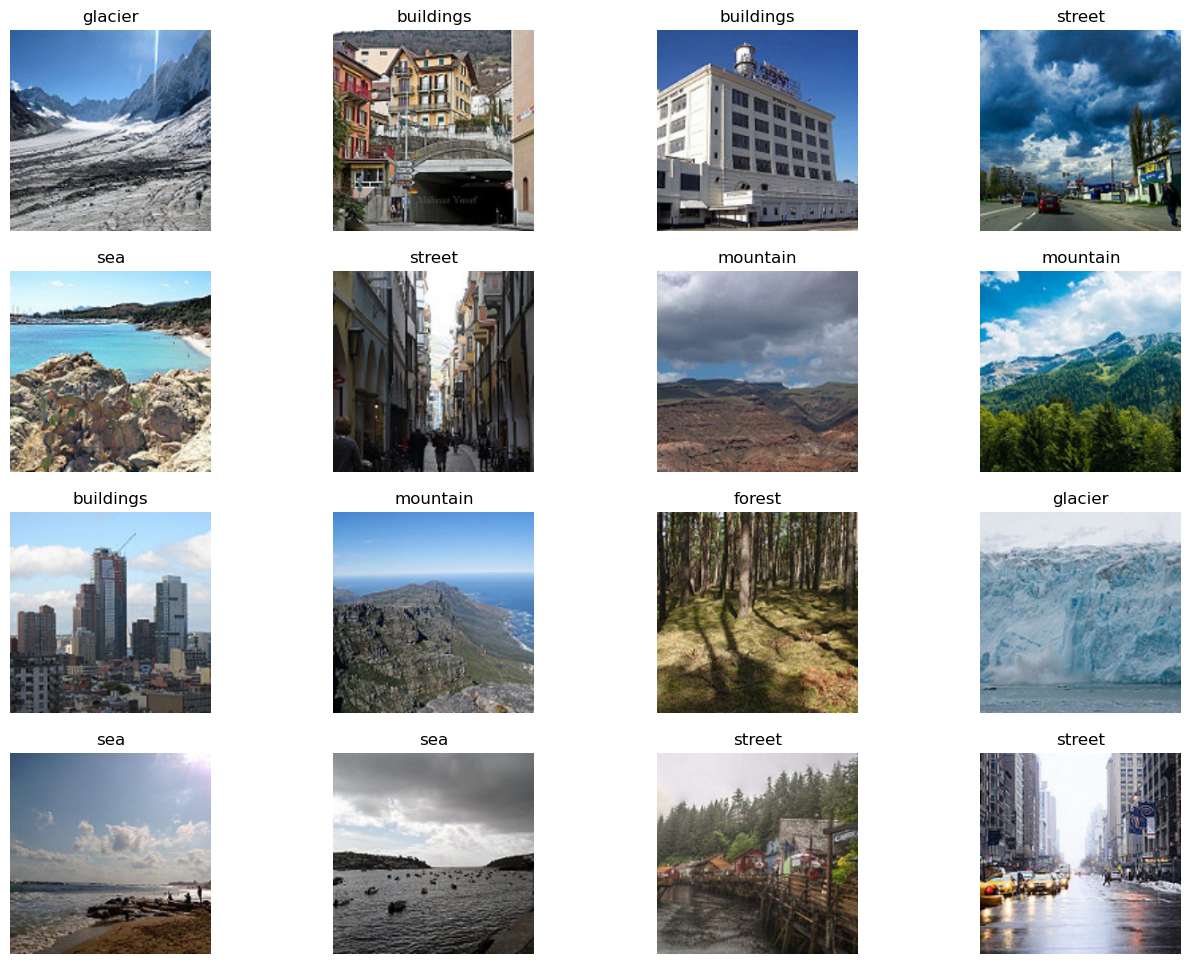

In [4]:
# Visualize a batch
def show_batch(Xb, Yb):
    # reverese normalization 
    invTrans = transforms.Compose([ 
        transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
    ])

    Xb = invTrans(Xb) # reverse normalization
    Yb = Yb.tolist()
    
    labels = [tr_val_dataset.classes[y] for y in Yb] # convert ints to labels

    fig, axes = plt.subplots(nrows=int(batch_size**0.5), ncols=int(batch_size**0.5), figsize=(16,12))

    i = 0
    for ax, label in zip(axes.flat, labels):
        ax.imshow(Xb[i].permute(1,2,0), label=label)
        ax.set(title=label)
        ax.axis('off')
        i += 1

    plt.show()

Xb, Yb = next(iter(tr_dl))
show_batch(Xb, Yb)

In [5]:
class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        # define layers
        # self.layer1 = nn.Sequential(
        #     nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2)
        # )
        # self.layer2 = nn.Sequential(
        #     nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        # )
        # self.layer3 = nn.Sequential(
        #     nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        #     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        #     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        # )
        # self.layer4 = nn.Sequential(
        #     nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        # )
        # self.layer5 = nn.Sequential(
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        # )
        # self.layer6 = nn.Sequential(nn.Flatten(),
        #     nn.ReLU(),
        #     # 7*7*512 = 25088
        #     nn.Linear(25088, 4096),
        #     nn.ReLU(),
        #     nn.Linear(4096, 4096),
        #     nn.ReLU(),
        #     nn.Linear(4096, 6)
        # )

        self.network = nn.Sequential(
            # input = 3, 224, 224 
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            nn.Dropout(0.5),
            # 7*7*512 = 25088
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 6)
            )
        
    
    def forward(self, x):
        # out = self.layer1(x)
        # out = self.layer2(out)
        # out = self.layer3(out)
        # out = self.layer4(out)
        # out = self.layer5(out)
        # out = self.layer6(out)
        # return out
        return self.network(x)

In [6]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, criterion, scheduler: torch.optim.lr_scheduler, batches: torch.utils.data.DataLoader, n_epochs: int) -> np.array:
    loss, vloss, vacc = np.empty(n_epochs), np.empty(n_epochs), np.empty(n_epochs)

    for i in range(n_epochs):

        # Train model
        model.train(True)
        running_loss = 0
        for j, batch in enumerate(tr_dl):
            optimizer.zero_grad()
            Xb, Yb = batch
            Xb, Yb = Xb.to(device), Yb.to(device)
            out = model.forward(Xb)
            lossi = criterion(out, Yb)
            lossi.backward()
            optimizer.step()
            running_loss += lossi.item()

        # Evaluate model on validation set
        model.eval()
        running_vloss = 0
        running_vacc = 0
        for vbatch in val_dl:  
            vXb, vYb = vbatch
            vXb, vYb = vXb.to(device), vYb.to(device)
            vout = model.forward(vXb)
            vlossi = criterion(vout, vYb)
            running_vloss += vlossi.item()
            _, vpred = torch.max(vout, dim=1)
            running_vacc += torch.sum(torch.eq(vpred, vYb)).item()/len(vYb)

        loss[i] = running_loss / len(tr_dl)
        vloss[i] = running_vloss / len(val_dl)
        vacc[i] = running_vacc / len(val_dl)
        scheduler.step(vloss[i])

        print(f"Epoch: {i+1}, Training loss: {loss[i]}, Validation loss: {vloss[i]}, Validation accuracy: {vacc[i]}, Learning rate: {optimizer.param_groups[0]['lr']}")

    return loss, vloss, vacc

    
model = VGG16().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-5, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=0)
n_epochs = 12

loss, vloss, vacc = train(model, optimizer, criterion, scheduler, tr_dl, n_epochs)


Epoch: 1, Training loss: 1.6411377853107196, Validation loss: 1.3146049624139613, Validation accuracy: 0.5137310606060606, Learning rate: 5e-05
Epoch: 2, Training loss: 1.191495606550902, Validation loss: 0.9617427384311502, Validation accuracy: 0.6267992424242425, Learning rate: 5e-05
Epoch: 3, Training loss: 0.9466768760463827, Validation loss: 0.8789480154712995, Validation accuracy: 0.6546401515151514, Learning rate: 5e-05
Epoch: 4, Training loss: 0.8254975905447159, Validation loss: 0.7428619597445835, Validation accuracy: 0.7142992424242424, Learning rate: 5e-05
Epoch: 5, Training loss: 0.7230744019510279, Validation loss: 0.6377293145792051, Validation accuracy: 0.7671401515151516, Learning rate: 5e-05
Epoch: 6, Training loss: 0.6337484370407725, Validation loss: 0.5786404117490306, Validation accuracy: 0.796969696969697, Learning rate: 5e-05
Epoch: 7, Training loss: 0.5868228942894904, Validation loss: 0.5167206909055962, Validation accuracy: 0.8111742424242424, Learning rate: 

Text(0.5, 1.0, 'Accuracy plot')

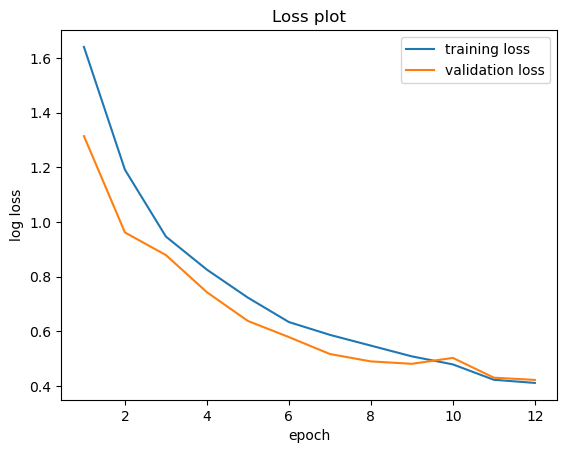

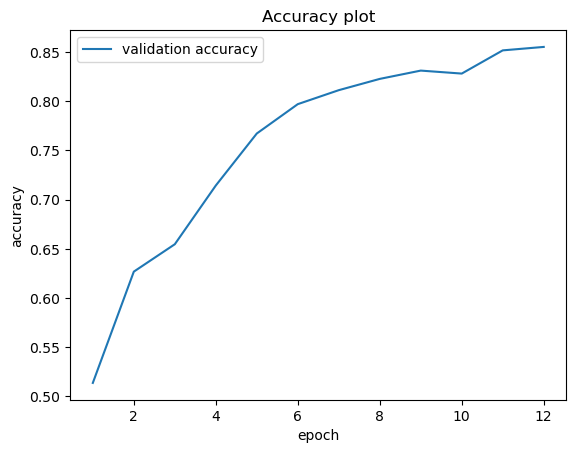

In [7]:
# plot loss
plt.figure(0)
xaxis = np.arange(1, n_epochs+1)
plt.plot(xaxis, loss, label='training loss')
plt.plot(xaxis, vloss, label='validation loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('log loss')
plt.title('Loss plot')

# plot accuracy
plt.figure(1)
plt.plot(xaxis, vacc, label='validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy plot')

In [8]:
# load saved model
load = False
if load:
    model = torch.load('models/model2', map_location=torch.device(device))

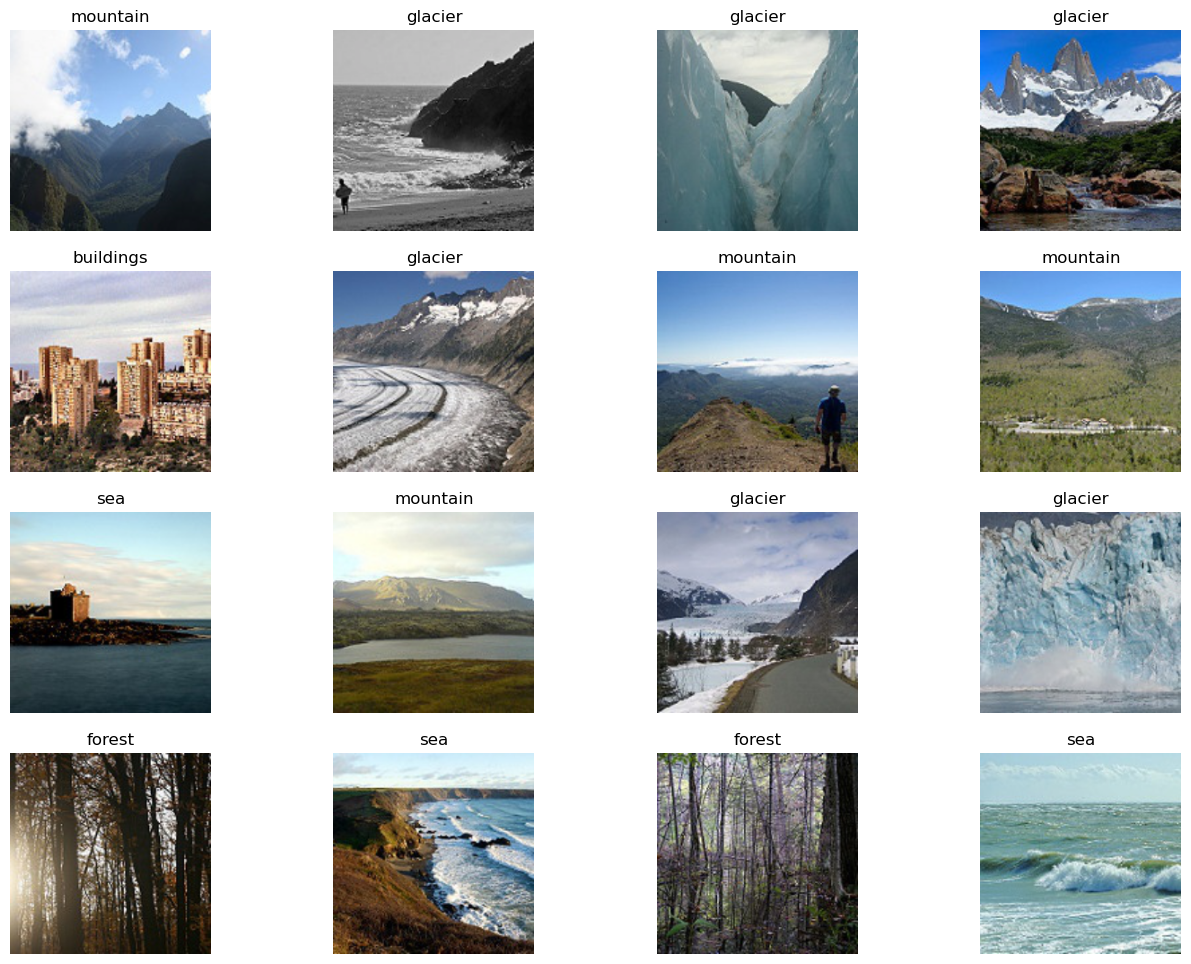

In [9]:
# show images and corresponding predictions
def predict(model: nn.Module, dataloader: torch.utils.data.DataLoader) -> None:
    model.train(False)
    Xb, _ = next(iter(dataloader))
    Xb = Xb.to(device)
    out = model.forward(Xb)
    Xb = Xb.to('cpu')
    out = out.to('cpu')
    _, pred = torch.max(out, dim=1)
    show_batch(Xb, pred)


predict(model, val_dl)

In [10]:
# save model
save = False
if save:
    torch.save(model.state_dict(), "models/model3_state_dict")
    torch.save(model, "models/model3")